# Test coloc between eQTLs from different genes

In [1]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls")

source("script/packages.R"  )
source("script/input_data.R")
source("script/functions.R" )
source("script/colors.R"    )


In [2]:
geneinfo = fread("pipeline/1.2.expression/gene_info.txt"                       , sep = "\t", header = TRUE, data.table = FALSE)
eqtls    = fread("pipeline/3.2.eqtls/eqtls/cardiac_eqtls.gene.egenes.txt"      , sep = "\t", header = TRUE, data.table = FALSE)
ints     = fread("pipeline/3.2.eqtls/eqtls/cardiac_eqtls.gene.interactions.txt", sep = "\t", header = TRUE, data.table = FALSE)
coloc    = fread("pipeline/3.2.eqtls/eqtl_overlap/cardiac_eqtls.gene.txt"      , sep = "\t", header = TRUE, data.table = FALSE)
ints     = ints[ints $cell == TRUE,]
gene2int = aggregate(interaction ~ transcript_id + gene_name, data = ints, FUN = function(x){paste(sort(unique(x)), collapse = "; ")})
coloc    = merge(geneinfo[,c("transcript_id", "gene_name", "gene_type", "start", "end", "strand")], coloc, by.x = "transcript_id", by.y = "transcript_id1")
coloc    = merge(geneinfo[,c("transcript_id", "gene_name", "gene_type", "start", "end", "strand")], coloc, by.x = "transcript_id", by.y = "transcript_id2", suffixes = 1:2)
colnames(coloc)[[1]] = "transcript_id1"

In [3]:
nrow(coloc[coloc$PP.H4.abf >= 0.5,])

[1] 7753

In [4]:
tocell = coloc[coloc$PP.H4.abf >= 0.5,]

tocell = cbind(tocell, as.data.frame(rbindlist(lapply(1:nrow(tocell), function(ii)
{
    transcript_id1 = tocell[ii, "transcript_id1"]
    transcript_id2 = tocell[ii, "transcript_id2"]
    type1          = tocell[ii, "type1"         ]
    type2          = tocell[ii, "type2"         ]

    int1 = ints[ints$transcript_id == transcript_id1 & ints$type == type1, "interaction"]
    int2 = ints[ints$transcript_id == transcript_id2 & ints$type == type2, "interaction"]
    
    int1_cell   = int1[grepl("cibersort", int1) == TRUE ]
    int2_cell   = int2[grepl("cibersort", int2) == TRUE ]
    int1_tissue = int1[grepl("cibersort", int1) == FALSE]
    int2_tissue = int2[grepl("cibersort", int2) == FALSE]
    
    is_adult1     = FALSE
    is_adult2     = FALSE
    is_ipsc_cvpc1 = FALSE
    is_ipsc_cvpc2 = FALSE
    
    if("adult"     %in% int1){is_adult1     = TRUE}
    if("adult"     %in% int2){is_adult2     = TRUE}
    if("ipsc_cvpc" %in% int1){is_ipsc_cvpc1 = TRUE}
    if("ipsc_cvpc" %in% int2){is_ipsc_cvpc2 = TRUE}

    out  = data.frame(cell1          = paste(c        (int1_cell  , int1_tissue), collapse = "; "),
                      cell2          = paste(c        (int2_cell  , int2_tissue), collapse = "; "),
                      overlap_cell   = paste(intersect(int1_cell  , int2_cell  ), collapse = "; "), 
                      only1_cell     = paste(setdiff  (int1_cell  , int2_cell  ), collapse = "; "), 
                      only2_cell     = paste(setdiff  (int2_cell  , int1_cell  ), collapse = "; "),
                      overlap_tissue = paste(intersect(int1_tissue, int2_tissue), collapse = "; "), 
                      only1_tissue   = paste(setdiff  (int1_tissue, int2_tissue), collapse = "; "), 
                      only2_tissue   = paste(setdiff  (int2_tissue, int1_tissue), collapse = "; "),
                      jaccard_cell   = length(intersect(int1_cell  , int2_cell  )) / length(unique(c(int1_cell  , int2_cell  ))),
                      jaccard_tissue = length(intersect(int1_tissue, int2_tissue)) / length(unique(c(int1_tissue, int2_tissue))),
                      is_adult1      = is_adult1    ,
                      is_adult2      = is_adult2    ,
                      is_ipsc_cvpc1  = is_ipsc_cvpc1,
                      is_ipsc_cvpc2  = is_ipsc_cvpc2
                     )
    
    return(out)
})), stringsAsFactors = FALSE))

tocell$is_overlap_cell   = FALSE
tocell$is_only1_cell     = FALSE
tocell$is_only2_cell     = FALSE
tocell$is_overlap_tissue = FALSE
tocell$is_only1_tissue   = FALSE
tocell$is_only2_tissue   = FALSE

tocell[tocell$overlap_cell   != "", "is_overlap_cell"  ] = TRUE
tocell[tocell$only1_cell     != "", "is_only1_cell"    ] = TRUE
tocell[tocell$only2_cell     != "", "is_only2_cell"    ] = TRUE
tocell[tocell$overlap_tissue != "", "is_overlap_tissue"] = TRUE
tocell[tocell$only1_tissue   != "", "is_only1_tissue"  ] = TRUE
tocell[tocell$only2_tissue   != "", "is_only2_tissue"  ] = TRUE

for(cell in sort(unique(ints$interaction)))
{
    tocell[, paste(cell, 1, sep = "")] = FALSE
    tocell[, paste(cell, 2, sep = "")] = FALSE
    
    tocell[grepl(cell, tocell$cell1) == TRUE, paste(cell, 1, sep = "")] = TRUE
    tocell[grepl(cell, tocell$cell2) == TRUE, paste(cell, 2, sep = "")] = TRUE
}

fwrite(tocell, "pipeline/3.2.eqtls/eqtl_overlap/cardiac_eqtls.gene2gene.cell_type_differences.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


# if one is iPSC-CVPC-specific, will the other be too?

In [5]:
calculate_overlap = function(tocell, x, perm = 0)
{
    tocell$x1 = tocell[,paste(x, 1, sep = "")]
    tocell$x2 = tocell[,paste(x, 2, sep = "")]
    
    if(perm > 0)
    {
        tocell$x1 = sample(tocell$x1, size = nrow(tocell), replace = FALSE)
        tocell$x2 = sample(tocell$x2, size = nrow(tocell), replace = FALSE)
    }
    
    out = data.frame(cell = sub("is_", "", x), perm = perm, or = nrow(tocell[tocell$x1 == TRUE | tocell$x2 == TRUE,]), and = nrow(tocell[tocell$x1 == TRUE & tocell$x2 == TRUE,]))
    return(out)
}

overlap = as.data.frame(rbindlist(lapply(sort(unique(ints$interaction)), function(x)
{
    as.data.frame(rbindlist(lapply(0:1000, function(perm)
    {
        calculate_overlap(tocell, x, perm)
    })), stringsAsFactors = FALSE)
})), stringsAsFactors = FALSE)

fwrite(overlap, "pipeline/3.2.eqtls/eqtl_overlap/cardiac_eqtls.gene2gene.cell_type_permutations.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


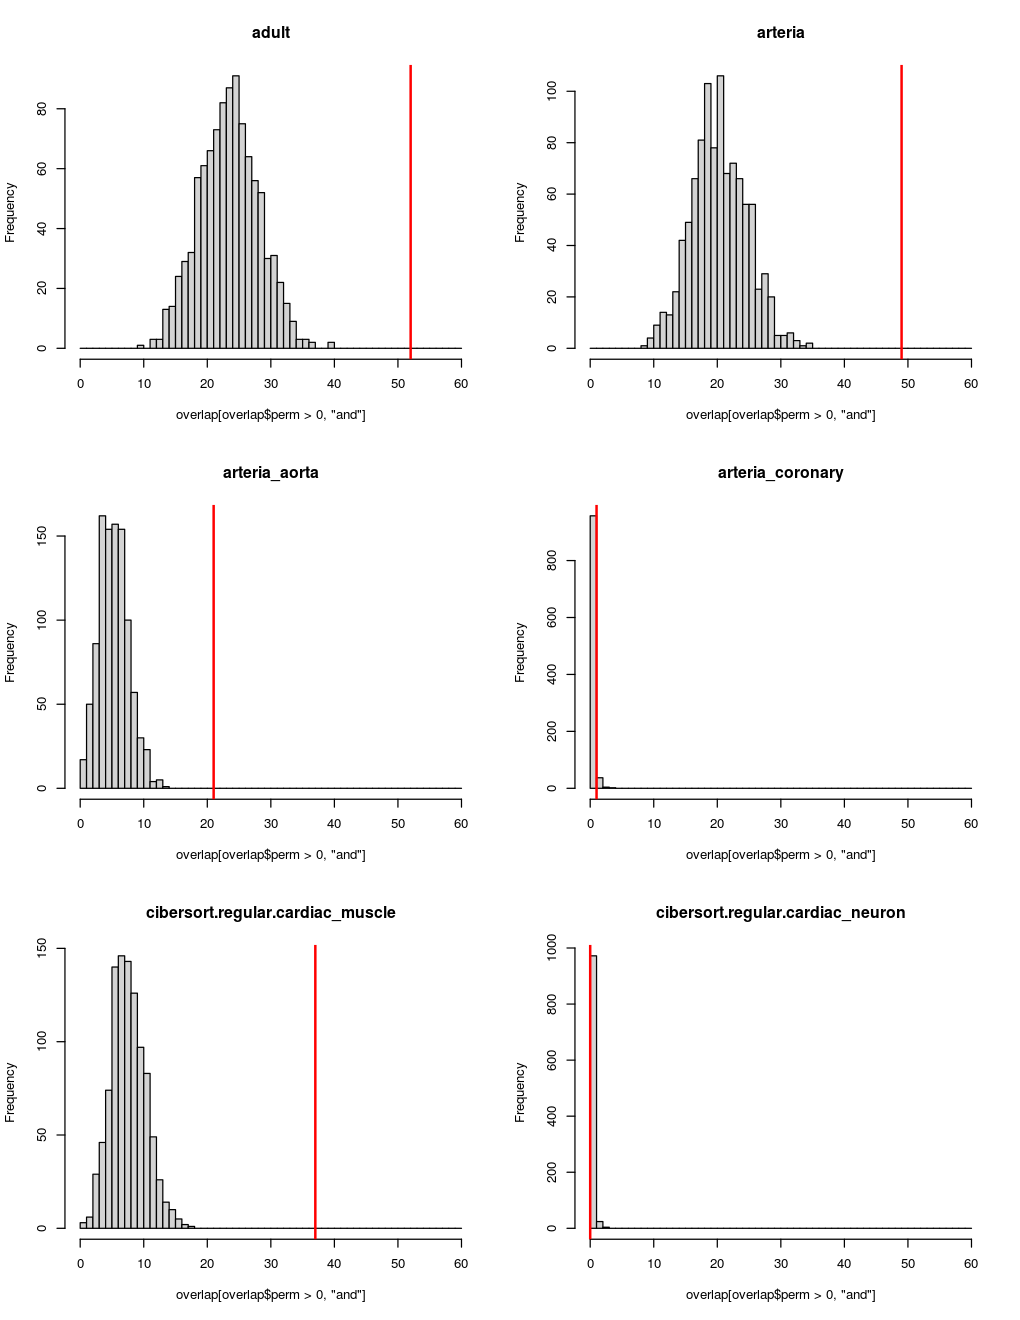

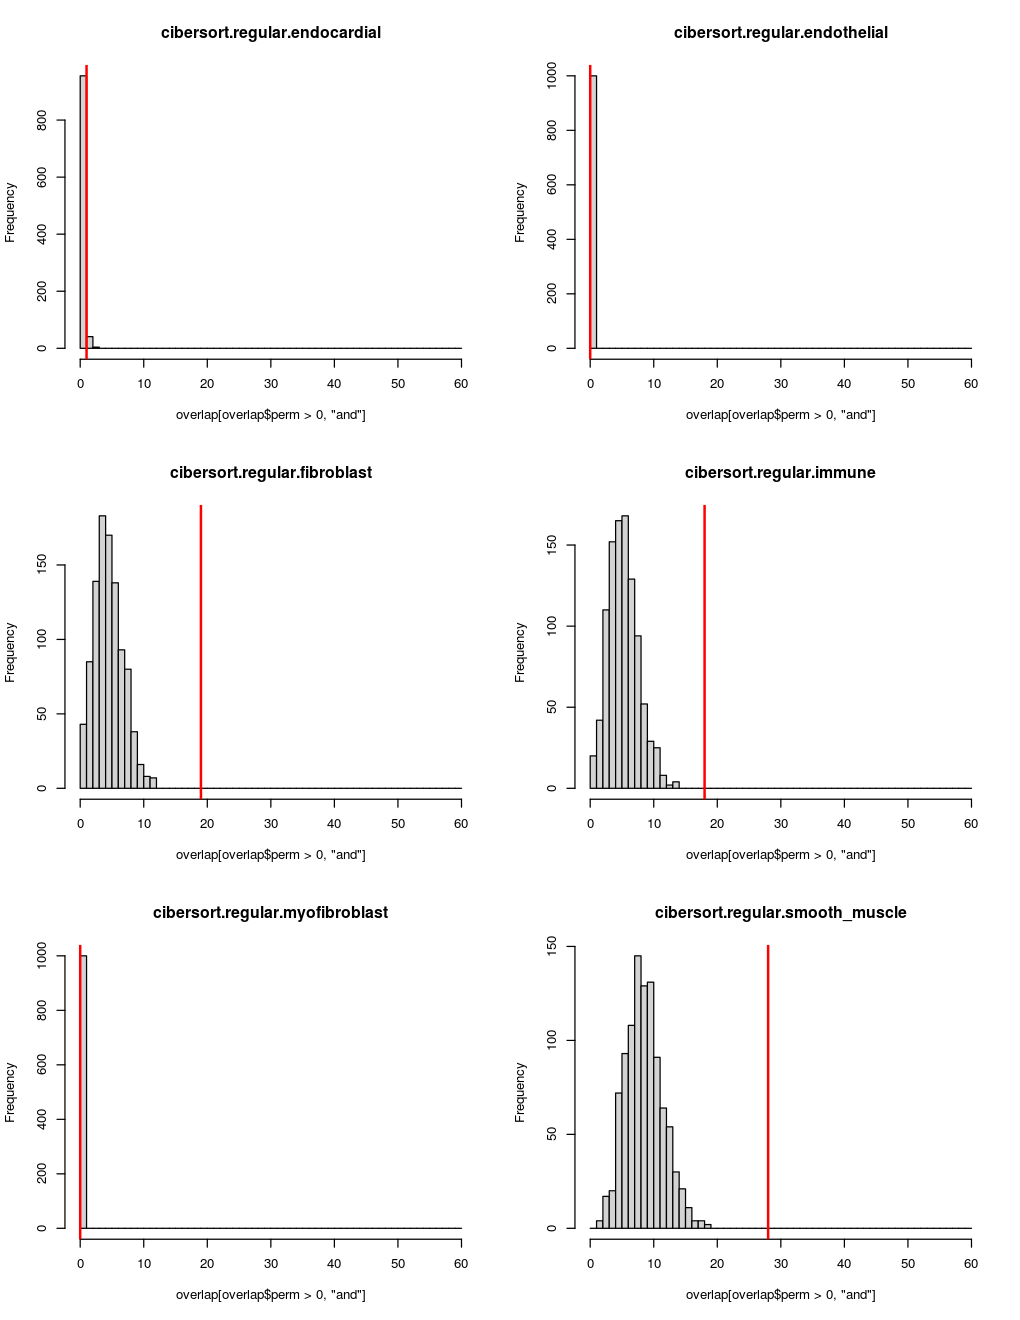

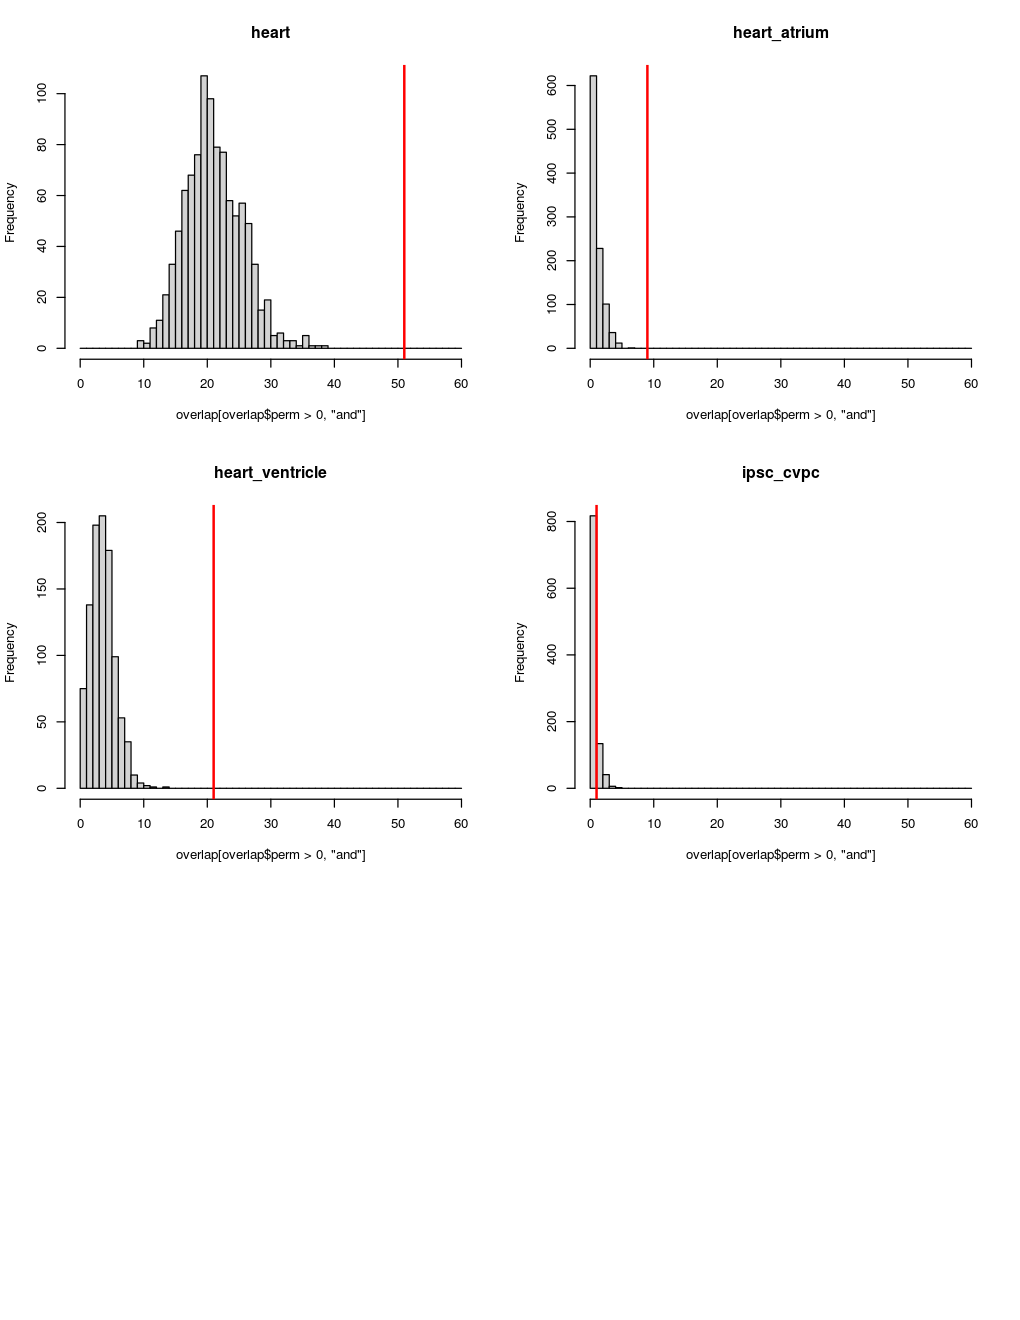

In [6]:
plot_overlap = function(overlap, cell)
{
    overlap = overlap[overlap$cell == cell,]
    xlims = range(overlap$and)
    
    hist(overlap[overlap$perm > 0, "and"], breaks = 0:60, xlim = c(0,60), main = cell)
    abline(v = overlap[overlap$perm == 0, "and"], col = "#ff0000", lwd = 2)
    
    my_mean = mean(overlap[overlap$perm > 0, "and"])
    my_sd   = sd  (overlap[overlap$perm > 0, "and"])
    
    zscore = (overlap[overlap$perm == 0, "and"] - my_mean) / my_sd
    pval   = 2*(1 - pnorm(overlap[overlap$perm == 0, "and"], mean = my_mean, sd = my_sd))
    
    out = data.frame(cell = cell, zscore = zscore, pval = min(c(1, pval)))
    
    return(out)
}

options(repr.plot.width = 8.5, repr.plot.height = 11)
layout(matrix(1:6, nrow = 3, byrow = TRUE))

tests = as.data.frame(rbindlist(lapply(sort(unique(ints$interaction)), function(cell){plot_overlap(overlap, cell)})), stringsAsFactors = FALSE)



In [7]:
tests
# add number of genes


cell,zscore,pval
<chr>,<dbl>,<dbl>
adult,5.9979617,1.998097e-09
arteria,6.4657920,1.007696e-10
arteria_aorta,6.5667149,5.143730e-11
arteria_coronary,1.1054468,2.689660e-01
cibersort.regular.cardiac_muscle,10.5818922,0.000000e+00
cibersort.regular.cardiac_neuron,-0.5276313,1.000000e+00
cibersort.regular.endocardial,1.1591910,2.463783e-01
cibersort.regular.endothelial,NaN,0.000000e+00
cibersort.regular.fibroblast,6.1627355,7.149887e-10


In [8]:
str(overlap)

'data.frame':	16016 obs. of  4 variables:
 $ cell: chr  "adult" "adult" "adult" "adult" ...
 $ perm: int  0 1 2 3 4 5 6 7 8 9 ...
 $ or  : int  816 846 845 846 846 835 851 846 839 849 ...
 $ and : int  52 22 23 22 22 33 17 22 29 19 ...


# Make network

In [9]:
suppressPackageStartupMessages(library(igraph))
suppressPackageStartupMessages(library(colorspace))


In [10]:
cells      = sort(unique(ints$interaction))
cell2color = data.frame(cell = cells[grepl("cibersort.regular", cells) == TRUE], color = c("#bb0000", "#00bb00", "#ff8888", "#FF34B3", "#0000bb", "#cdcd00", "#3D3D3D", "#8B814C")) 


In [11]:
tonet = tocell

for(cell in sort(unique(ints$interaction)))
{
    tonet[,cell] = rowSums(tonet[, paste(cell, 1:2, sep = "")]) / 2
}

to_edges = tonet[,c("transcript_id1", "gene_name1", "gene_type1", "type1", 
                       "transcript_id2", "gene_name2", "gene_type2", "type2",
                       "PP.H4.abf", "id", "chrom", "pos", "ref", "alt", 
                       sort(unique(ints$interaction))
                      )]

edges        = unique(to_edges[,!colnames(to_edges) %in% sort(unique(ints$interaction))])
edges$weight = 3
edges$cell   = "no"
edges[,sort(unique(ints$interaction))] = FALSE

edges = rbind(edges, as.data.frame(rbindlist(lapply(sort(unique(ints$interaction)), function(cell)
{
    this        = to_edges[to_edges[,cell] > 0,]
    this$weight = this[,cell]
    this$cell   = cell
    
    return(this)
    
})), stringsAsFactors = FALSE))

edges = edges[edges$weight >= 1,]

edges[, sort(unique(ints$interaction))] = NULL

nodes1 = edges[, paste(c("transcript_id", "gene_name", "gene_type", "type"), 1, sep = "")]
nodes2 = edges[, paste(c("transcript_id", "gene_name", "gene_type", "type"), 2, sep = "")]

colnames(nodes1) = c("transcript_id", "gene_name", "gene_type", "type")
colnames(nodes2) = c("transcript_id", "gene_name", "gene_type", "type")

nodes = unique(rbind(nodes1, nodes2))

nodes$node_id  = paste(nodes$transcript_id , nodes$type )
edges$node_id1 = paste(edges$transcript_id1, edges$type1)
edges$node_id2 = paste(edges$transcript_id2, edges$type2)
edges          = merge(edges, rbind(cell2color, data.frame(cell = "no", color = "#000000")))

edges =        edges[,c("node_id1", "node_id2", "PP.H4.abf", "id", "weight", "cell", "color")]
nodes = unique(nodes[,c("node_id", "transcript_id", "gene_name", "gene_type", "type")])



In [12]:
mynet = graph_from_data_frame(d        = edges, 
                              vertices = nodes, 
                              directed = FALSE)


In [13]:
decomposed = decompose (mynet, min.vertices = 2)
components = components(mynet)
mygroups   = groups(components)
my_cliques = max_cliques(mynet)

In [78]:
clique2size = data.frame(clique = 1:length(my_cliques), size = unlist(lapply(my_cliques, length)))
clique2size = clique2size[order(clique2size$size, decreasing = TRUE),]

ns
   2    3    4    5    6    7 
5572  570  114   31    5    1 

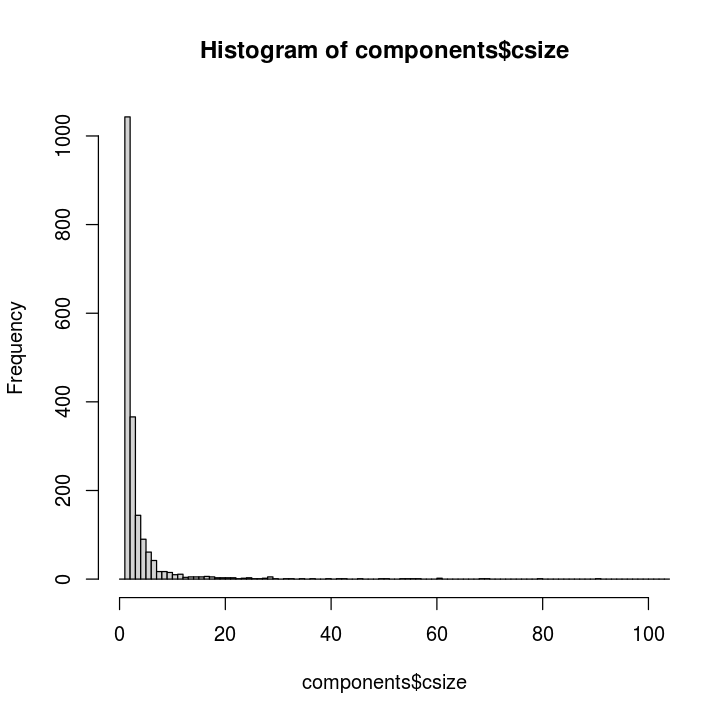

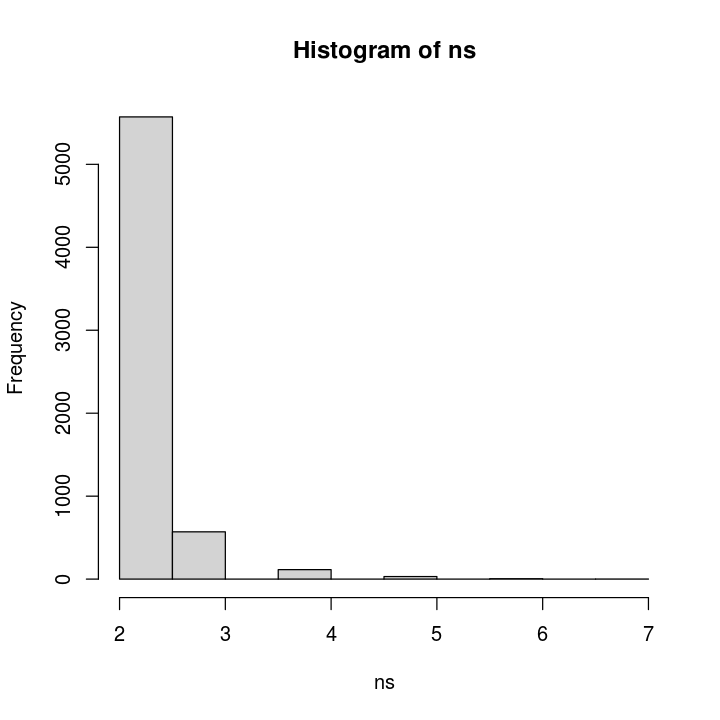

In [14]:
options(repr.plot.width = 6, repr.plot.height = 6)

hist(components$csize, breaks = 0:500, xlim = c(0,100))

ns = unlist(lapply(my_cliques, length))

sort(table(ns), decreasing = TRUE)

hist(ns)



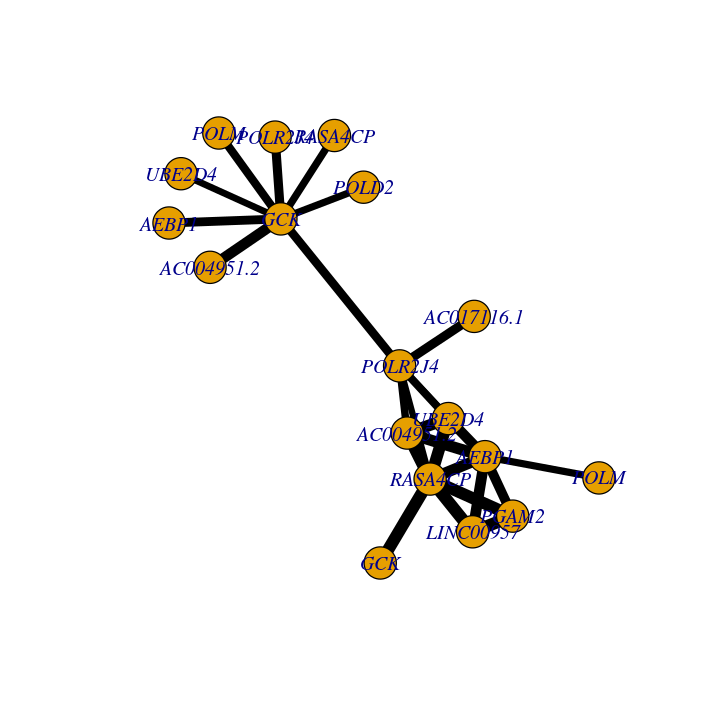

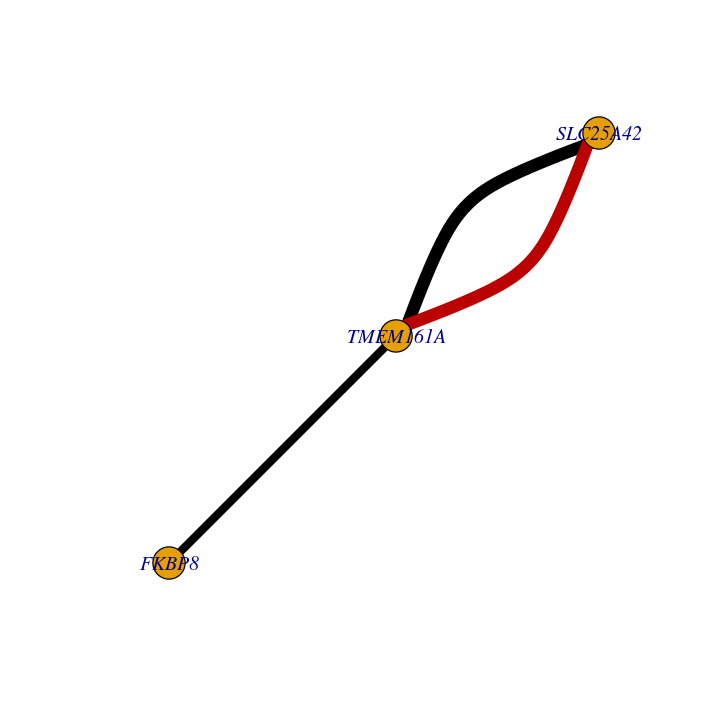

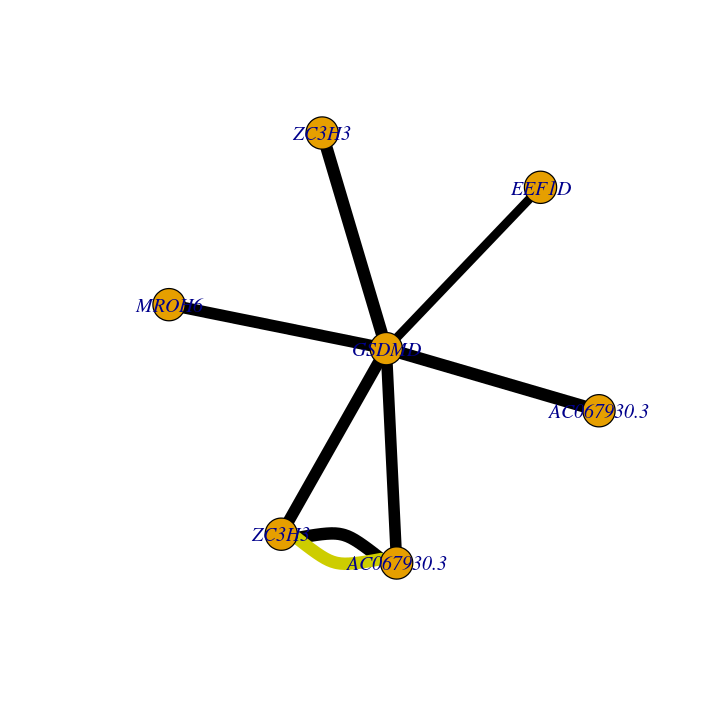

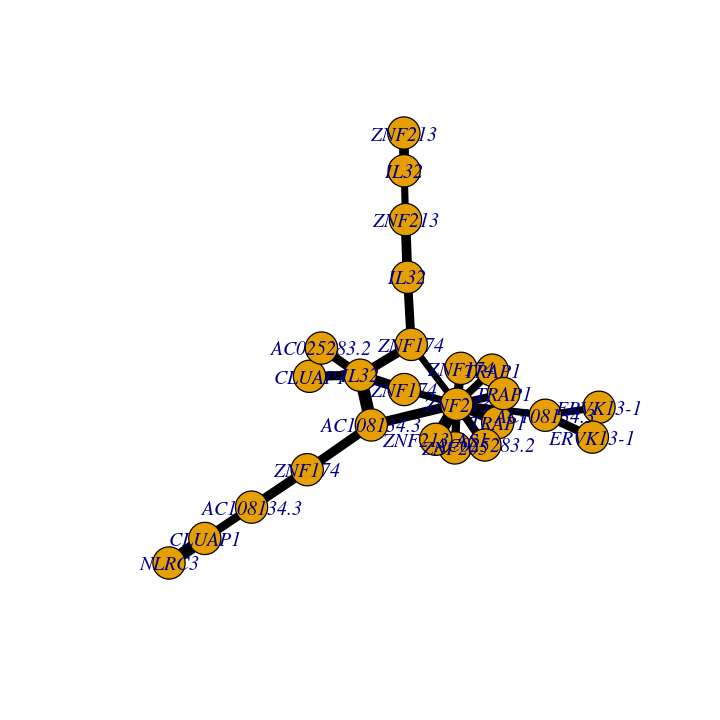

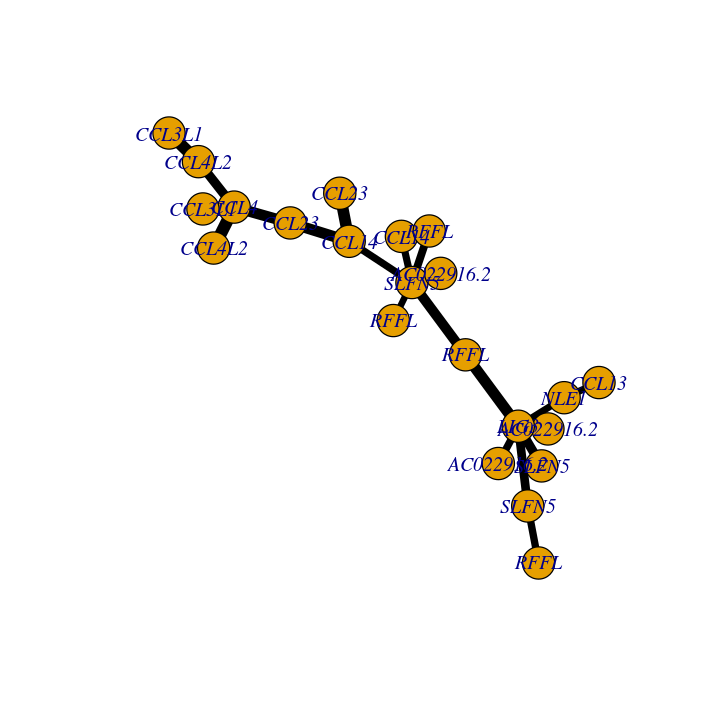

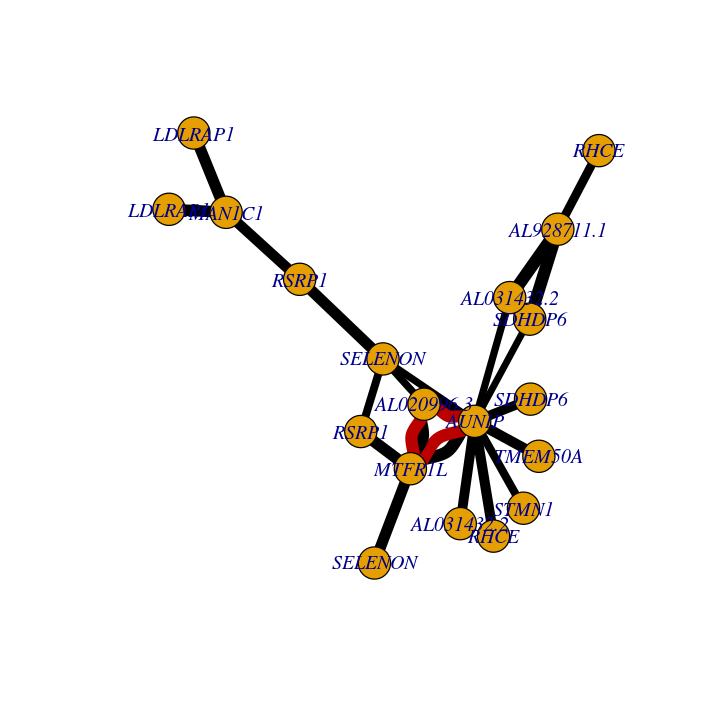

In [15]:
plot_component = function(ii, decomposed)
{
    this = decomposed[[ii]]
    
    plot(this, 
         edge.width         = E(this)$PP.H4.abf * 10, 
         edge.color         = E(this)$color, 
         vertex.shape       = "circle",
         vertex.label       = V(this)$gene_name,
         vertex.label.font  = 3
        )

}

plot_component(97, decomposed)
plot_component(87, decomposed)
plot_component(75, decomposed)
#plot_component(25, decomposed)
plot_component(24, decomposed)
plot_component(15, decomposed)
plot_component(168, decomposed)


# Test if cliques share more cell type associations

In [16]:
tocell$clique   = 1
tocell$tr2type1 = paste(tocell$transcript_id1, tocell$type1)
tocell$tr2type2 = paste(tocell$transcript_id2, tocell$type2)

for(clique in my_cliques)
{
    ids = names (clique)
    n   = length(ids   )
    
    tocell[tocell$tr2type1 %in% ids & tocell$tr2type2 %in% ids, "clique"] = n
}


In [17]:
calculate_overlap_clique = function(tocell, x, clique, perm = 0)
{
    tocell$x1 = tocell[,paste(x, 1, sep = "")]
    tocell$x2 = tocell[,paste(x, 2, sep = "")]
    
    if(perm > 0)
    {
        tocell$x1 = sample(tocell$x1, size = nrow(tocell), replace = FALSE)
        tocell$x2 = sample(tocell$x2, size = nrow(tocell), replace = FALSE)
    }
    
    out = data.frame(cell   = sub("is_", "", x), 
                     clique = clique,
                     perm   = perm, 
                     or     = nrow(tocell[tocell$clique >= clique & (tocell$x1 == TRUE | tocell$x2 == TRUE),]), 
                     and    = nrow(tocell[tocell$clique >= clique & (tocell$x1 == TRUE & tocell$x2 == TRUE),]))
    return(out)
}

overlap_clique = as.data.frame(rbindlist(lapply(sort(unique(tocell$clique)), function(clique)
{
    as.data.frame(rbindlist(lapply(sort(unique(ints$interaction)), function(x)
    {
        as.data.frame(rbindlist(lapply(0:100, function(perm)
        {
            calculate_overlap_clique(tocell, x, clique, perm)
        })), stringsAsFactors = FALSE)
    })), stringsAsFactors = FALSE)
})), stringsAsFactors = FALSE)

fwrite(overlap_clique, "pipeline/3.2.eqtls/eqtl_overlap/cardiac_eqtls.gene2gene.cell_type_permutations_clique.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


In [18]:
test_overlap_clique = function(overlap, cell, clique)
{
    #if(clique == 1){totest = 1:max(overlap$clique)}
    #if(clique >  1){totest = c(clique)            }
    #overlap = overlap[overlap$cell == cell & overlap$clique %in% clique,]
    
    overlap = overlap[overlap$cell == cell & overlap$clique == clique,]
    #xlims = range(overlap$and)
    
    #hist(overlap[overlap$perm > 0, "and"], breaks = 0:60, xlim = c(0,60), main = cell)
    #abline(v = overlap[overlap$perm == 0, "and"], col = "#ff0000", lwd = 2)
    
    my_mean = mean(overlap[overlap$perm > 0, "and"])
    my_sd   = sd  (overlap[overlap$perm > 0, "and"])
    zscore  = (overlap[overlap$perm == 0, "and"] - my_mean) / my_sd
    pval    = 2*(1 - pnorm(overlap[overlap$perm == 0, "and"], mean = my_mean, sd = my_sd))
    out     = data.frame(cell = cell, clique = clique, zscore = zscore, pval = min(c(1, pval)))
    
    return(out)
}

options(repr.plot.width = 8.5, repr.plot.height = 11)
layout(matrix(1:6, nrow = 3, byrow = TRUE))

tests_clique = as.data.frame(rbindlist(lapply(sort(unique(tocell$clique)), function(clique)
{
    as.data.frame(rbindlist(lapply(sort(unique(ints$interaction)), function(cell)
    {
        test_overlap_clique(overlap_clique, cell, clique)
    })), stringsAsFactors = FALSE)
})), stringsAsFactors = FALSE)

fwrite(tests_clique, "pipeline/3.2.eqtls/eqtl_overlap/cardiac_eqtls.gene2gene.cell_type_permutations_clique.tests.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


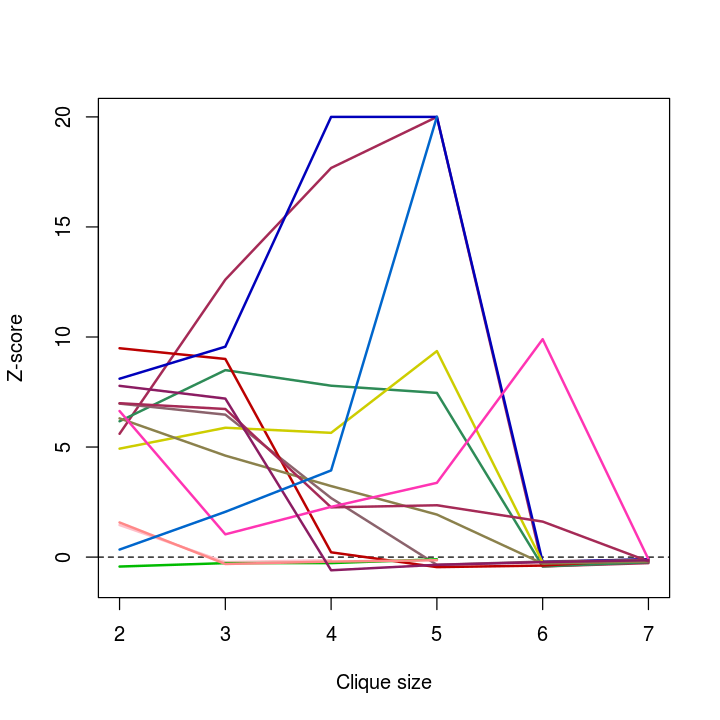

In [19]:
tocolor = rbind(cell2color, 
                data.frame(cell = tissue2color[tissue2color$tissue != "ipsc_cvpc", "tissue"], color = tissue2color[tissue2color$tissue != "ipsc_cvpc", "color"]),
                data.frame(cell = tissue2color3$tissue, color = tissue2color3$color)
               )

options(repr.plot.width = 6, repr.plot.height = 6)
plot(1,1, type = "n", xlim = c(2,7), ylim = c(-1,20), xlab = "Clique size", ylab = "Z-score")

abline(h = 0, lty = "dashed")

invisible(lapply(sort(unique(ints$interaction)), function(cell)
{
    this = tests_clique[ tests_clique$cell == cell, ]
    this$zscore = unlist(lapply(this$zscore, function(x){min(c(x, 20))}))
    lines(this$clique, this$zscore, col = tocolor[tocolor$cell == cell, "color"], lwd = 2)
}))


In [20]:
tests_clique[tests_clique$cell == "ipsc_cvpc",]
tests_clique[tests_clique$cell == "adult"    ,]


,cell,clique,zscore,pval
,<chr>,<dbl>,<dbl>,<dbl>
16,ipsc_cvpc,2,0.3419823,7.323642e-01
32,ipsc_cvpc,3,2.0575383,3.963448e-02
48,ipsc_cvpc,4,3.9382737,8.206994e-05
64,ipsc_cvpc,5,Inf,0.000000e+00
80,ipsc_cvpc,6,NaN,0.000000e+00
96,ipsc_cvpc,7,NaN,0.000000e+00


,cell,clique,zscore,pval
,<chr>,<dbl>,<dbl>,<dbl>
1,adult,2,5.6020635,2.118149e-08
17,adult,3,12.6058964,0.000000e+00
33,adult,4,17.6785977,0.000000e+00
49,adult,5,20.5309635,0.000000e+00
65,adult,6,-0.4242641,1.000000e+00
81,adult,7,-0.2729764,1.000000e+00


# Are genes in cliques more likely to be associated with GWAS?

In [59]:
gwas = fread("pipeline/6.1.coloc_gwas/coloc.eqtls.gene.txt", sep = "\t", header = TRUE , data.table = FALSE)


In [60]:
gene2clique = data.frame(tr2type = c(tocell$tr2type1, tocell$tr2type2), clique = c(tocell$clique, tocell$clique))
gene2clique = aggregate(clique ~ tr2type, data = gene2clique, FUN = max)
gwas2clique = merge(gwas, gene2clique, all.x = TRUE)

gwas2clique[is.na(gwas2clique$clique) == TRUE, "clique"] = 1

In [61]:
gwas2test = aggregate(PP.H4.abf ~ tr2type + clique, data = gwas2clique, FUN = max)

## eGenes in cliques are more likely to colocalize with GWAS

In [62]:
summary(aov(PP.H4.abf ~ clique, data = gwas2test))[[1]][1,"Pr(>F)"]

[1] 3.328928e-85

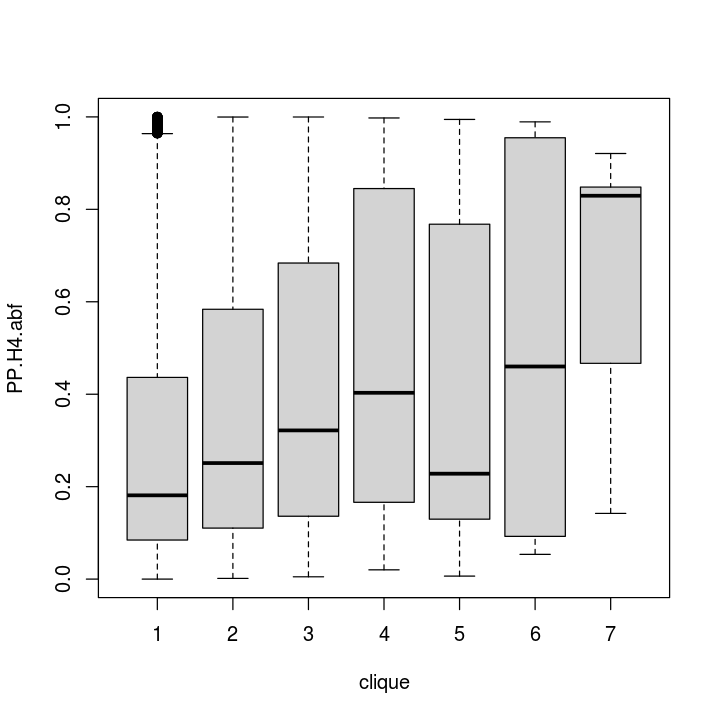

In [63]:
boxplot(PP.H4.abf ~ clique, data = gwas2test)

In [64]:
clique2gwas1      = data.frame(clique = 1:length(my_cliques), size = unlist(lapply(my_cliques, length)))
clique2gwas1$gwas = unlist(lapply(1:length(my_cliques), function(ii)
{
    this = names(my_cliques[[ii]])
    
    return(max(gwas2test[gwas2test$tr2type %in% this, "PP.H4.abf"]))
}))

clique2gwas2           = aggregate(PP.H4.abf ~ tr2type + clique, data = gwas2clique[gwas2clique$clique == 1,], FUN = max)
colnames(clique2gwas2) = c("clique", "size", "gwas")
clique2gwas            = rbind(clique2gwas1, clique2gwas2)


In [65]:
summary(aov(gwas ~ size, data = clique2gwas))[[1]][1,"Pr(>F)"]

[1] 0

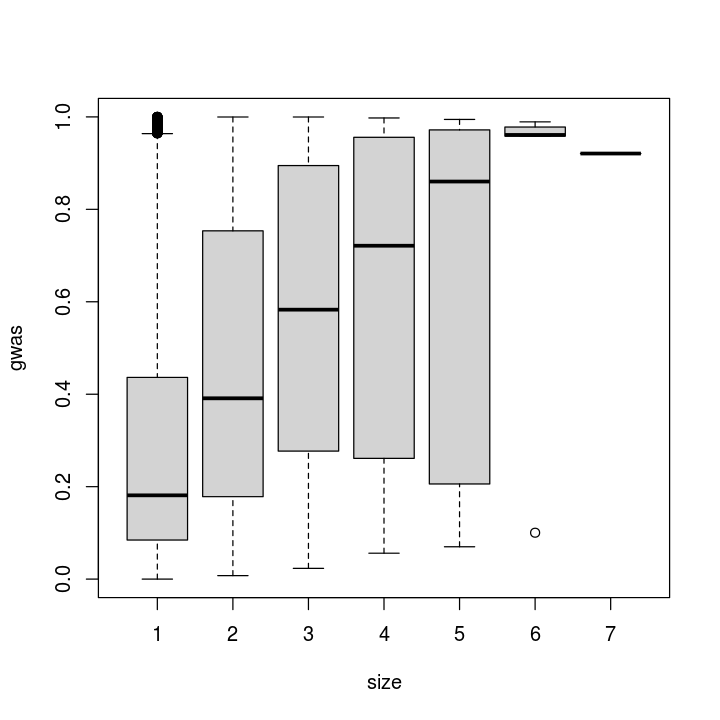

In [66]:
boxplot(gwas ~ size, data = clique2gwas)

# Are eGenes in cliques more likely to be associated with multiple traits?

In [67]:
gwas2test_n = aggregate(trait ~ tr2type + clique, data = gwas2clique, FUN = function(x){paste(x, collapse = ";")})

In [68]:
clique2gwas1      = data.frame(clique = 1:length(my_cliques), size = unlist(lapply(my_cliques, length)))
clique2gwas1$gwas = unlist(lapply(1:length(my_cliques), function(ii)
{
    this = unlist(names(my_cliques[[ii]]))
    
    return(length(unique(gwas[gwas$tr2type %in% this & gwas$PP.H4.abf >= 0.5,"trait"])))
}))



In [69]:
clique2gwas2      = data.frame(clique = sort(unique(gwas2clique[gwas2clique$clique == 1, "tr2type"])), size = 1, gwas = 0)
clique2gwas2$gwas = unlist(lapply(1:nrow(clique2gwas2), function(ii)
{
    this = clique2gwas2[ii, "clique"]
    
    return(length(unique(gwas[gwas$tr2type == this & gwas$PP.H4.abf >= 0.5,"trait"])))
}))


In [70]:
clique2gwas_n = rbind(clique2gwas1, clique2gwas2)


In [71]:
summary(aov(gwas ~ size, data = clique2gwas_n))[[1]][1,"Pr(>F)"]

[1] 5.693497e-166

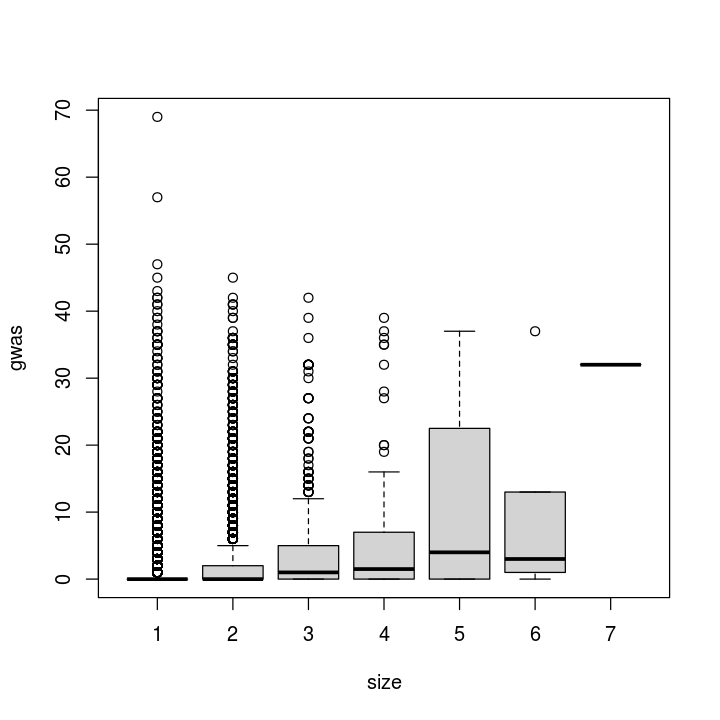

In [72]:
boxplot(gwas ~ size, data = clique2gwas_n)

# Examples of genes in cliques and GWAS

In [116]:
manifest = fread("pipeline/6.1.coloc_gwas/traits.manifest.txt", sep = "\t", header = TRUE, data.table = FALSE)


In [130]:
clique2size[clique2size$size >= 6, ]

this = 6276
a1 = geneinfo[geneinfo$gene_id %in% unlist(lapply(names(my_cliques[[this]]), function(x){unlist(strsplit(x, " "))[[1]]})),]
a2 = eqtls   [eqtls   $gene_id %in% unlist(lapply(names(my_cliques[[this]]), function(x){unlist(strsplit(x, " "))[[1]]})) & eqtls$type == 0, c("gene_id", "gene_name", "id", "pos", "beta", "qval")]
a4 = ints    [ints    $gene_id %in% unlist(lapply(names(my_cliques[[this]]), function(x){unlist(strsplit(x, " "))[[1]]})), c("gene_id", "gene_name", "interaction")]
a3 = merge(gwas    [gwas    $tr2type %in% names(my_cliques[[this]]) & gwas$PP.H4.abf > 0.5,], manifest[,c("id", "description")], by.x = "trait", by.y = "id")

a1[order(a1$gene_name),]
a2[order(a2$pos      ),]
a4
a3[order(a3$PP.H4.abf, decreasing = TRUE),]

my_cliques[[this]]


my_cliques[clique2size[clique2size$size >= 6, "clique"]]


,clique,size
,<int>,<int>
6259,6259,7
6232,6232,6
6233,6233,6
6234,6234,6
6251,6251,6
6276,6276,6


,chrom,start,end,strand,gene_id,gene_name,gene_type,havana_gene,transcript_id
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
17805,chr7,102277496,102312088,-,ENSG00000267645.5_6,AC105052.3,protein_coding,OTTHUMG00000180801.1_6,ENSG00000267645.5_6
17806,chr7,102305815,102312076,-,ENSG00000228049.7_5,POLR2J2,protein_coding,OTTHUMG00000150388.1_5,ENSG00000228049.7_5
17797,chr7,102178365,102213100,-,ENSG00000168255.20_8,POLR2J3,protein_coding,OTTHUMG00000150384.1_8,ENSG00000168255.20_8
17802,chr7,102220093,102257204,-,ENSG00000105808.13,RASA4,protein_coding,OTTHUMG00000150383.5,ENSG00000105808.13
17796,chr7,102122892,102158228,-,ENSG00000170667.14_7,RASA4B,protein_coding,OTTHUMG00000022944.1_7,ENSG00000170667.14_7
17804,chr7,102277472,102283238,-,ENSG00000267368.1_9,UPK3BL1,protein_coding,OTTHUMG00000165036.1_9,ENSG00000267368.1_9


,gene_id,gene_name,id,pos,beta,qval
,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>
5149,ENSG00000105808.13,RASA4,VAR_7_102112100_G_A,102112100,-0.6329347,9.039532e-07
19868,ENSG00000170667.14_7,RASA4B,VAR_7_102112100_G_A,102112100,-0.6598837,2.939916e-07
34096,ENSG00000267368.1_9,UPK3BL1,VAR_7_102347440_T_A,102347440,1.2829250,3.208996e-18
19088,ENSG00000168255.20_8,POLR2J3,VAR_7_102368966_A_G,102368966,-0.8957719,2.301389e-14
34185,ENSG00000267645.5_6,AC105052.3,VAR_7_102387467_G_T,102387467,1.6934676,1.750609e-26
28327,ENSG00000228049.7_5,POLR2J2,VAR_7_102421348_C_A,102421348,-0.7309981,1.004480e-07


gene_id,gene_name,interaction
<chr>,<chr>,<chr>


,trait,nsnps,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf,transcript_id,type,id,chrom,pos,ref,alt,af,pp_snp,tr2type,description
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,continuous-4079-both_sexes-irnt,991,3.202190e-05,0.009845555,6.065351e-06,0.0008756313,0.9892407,ENSG00000267645.5_6,1,VAR_7_102111936_G_A,7,102111936,G,A,0.363,0.9899498,ENSG00000267645.5_6 1,"Diastolic blood pressure, automated reading"
5,continuous-DBP-both_sexes-combined_medadj_irnt,991,5.132928e-05,0.015781863,1.320542e-05,0.0030791044,0.9810745,ENSG00000267645.5_6,1,VAR_7_102111936_G_A,7,102111936,G,A,0.363,0.9899027,ENSG00000267645.5_6 1,"Diastolic blood pressure, combined automated + manual reading, adjusted by medication"
6,continuous-DBP-both_sexes-combined_medadj_raw,991,5.703499e-05,0.017536160,9.439341e-06,0.0019217742,0.9804756,ENSG00000267645.5_6,1,VAR_7_102111936_G_A,7,102111936,G,A,0.363,0.9913811,ENSG00000267645.5_6 1,"Diastolic blood pressure, combined automated + manual reading, adjusted by medication"
4,continuous-DBP-both_sexes-combined_irnt,991,5.620564e-05,0.017281165,1.822437e-05,0.0046253035,0.9780191,ENSG00000267645.5_6,1,VAR_7_102111936_G_A,7,102111936,G,A,0.363,0.9900172,ENSG00000267645.5_6 1,"Diastolic blood pressure, combined automated + manual reading"
2,continuous-DBP-both_sexes-auto_medadj_irnt,991,6.633797e-05,0.020396484,9.495631e-06,0.0019419712,0.9775857,ENSG00000267645.5_6,1,VAR_7_102111936_G_A,7,102111936,G,A,0.363,0.9903547,ENSG00000267645.5_6 1,"Diastolic blood pressure, automated reading, adjusted by medication"
3,continuous-DBP-both_sexes-auto_medadj_raw,991,7.155692e-05,0.022001119,8.031162e-06,0.0014928600,0.9764264,ENSG00000267645.5_6,1,VAR_7_102111936_G_A,7,102111936,G,A,0.363,0.9916312,ENSG00000267645.5_6 1,"Diastolic blood pressure, automated reading, adjusted by medication"
7,continuous-DBP-both_sexes-combined_raw,991,7.027666e-05,0.021607484,1.399724e-05,0.0033286573,0.9749796,ENSG00000267645.5_6,1,VAR_7_102111936_G_A,7,102111936,G,A,0.363,0.9905086,ENSG00000267645.5_6 1,"Diastolic blood pressure, combined automated + manual reading"
8,continuous-MAP-both_sexes-auto_irnt,991,1.031577e-03,0.317171784,9.808235e-06,0.0023362205,0.6794506,ENSG00000267645.5_6,1,VAR_7_102111936_G_A,7,102111936,G,A,0.363,0.9889893,ENSG00000267645.5_6 1,"Mean arterial pressure, automated reading"
11,continuous-MAP-both_sexes-auto_raw,991,1.272218e-03,0.391160068,9.517558e-06,0.0023210614,0.6052371,ENSG00000267645.5_6,1,VAR_7_102111936_G_A,7,102111936,G,A,0.363,0.9882497,ENSG00000267645.5_6 1,"Mean arterial pressure, automated reading"


+ 6/8077 vertices, named, from 70f53df:
[1] ENSG00000267368.1_9 1  ENSG00000168255.20_8 1 ENSG00000105808.13 1  
[4] ENSG00000228049.7_5 1  ENSG00000267645.5_6 1  ENSG00000170667.14_7 1

[[1]]
+ 7/8077 vertices, named, from 70f53df:
[1] ENSG00000198064.13_7 0 ENSG00000102882.12_9 0 ENSG00000261740.6_8 0 
[4] ENSG00000205534.6_5 0  ENSG00000183604.14_6 0 ENSG00000181625.17_6 0
[7] ENSG00000169203.12 0  

[[2]]
+ 6/8077 vertices, named, from 70f53df:
[1] ENSG00000239779.7_8 0  ENSG00000115275.14_8 0 ENSG00000115274.15_6 0
[4] ENSG00000286883.1_2 0  ENSG00000204822.7_6 0  ENSG00000115282.21_8 0

[[3]]
+ 6/8077 vertices, named, from 70f53df:
[1] ENSG00000099977.14_5 0 ENSG00000099984.11_6 0 ENSG00000272787.1_7 0 
[4] ENSG00000240972.2_6 0  ENSG00000187792.5_5 0  ENSG00000133433.10_5 0

[[4]]
+ 6/8077 vertices, named, from 70f53df:
[1] ENSG00000259728.5_5 0  ENSG00000244056.2 0    ENSG00000225151.10_6 0
[4] ENSG00000259726.1_4 0  ENSG00000259683.1_5 0  ENSG00000259295.6_4 0 

[[5]]
+ 6/8077 vertices, named, from 70f53df:
[1] ENSG00000183336.8_5 0  ENSG00000169203.12 0   ENSG00000261740.6_8 0 
[4] ENSG00000205534.6_5 0  ENSG00000183604.14_6 0 ENSG00000181625.17_6 0

[[6]]
+ 

In [111]:
str(gwas)

'data.frame':	2011740 obs. of  17 variables:
 $ nsnps        : int  2817 2817 2817 2817 2815 2816 2563 2814 2817 2813 ...
 $ PP.H0.abf    : num  0.321 0.302 0.247 0.329 0.301 ...
 $ PP.H1.abf    : num  0.622 0.585 0.478 0.638 0.584 ...
 $ PP.H2.abf    : num  0.0167 0.0346 0.0834 0.0092 0.0336 ...
 $ PP.H3.abf    : num  0.0324 0.067 0.1616 0.0178 0.0651 ...
 $ PP.H4.abf    : num  0.00717 0.01221 0.03008 0.00592 0.0161 ...
 $ transcript_id: chr  "ENSG00000000457.14_7" "ENSG00000000457.14_7" "ENSG00000000457.14_7" "ENSG00000000457.14_7" ...
 $ type         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ id           : chr  "VAR_1_169860528_C_A" "VAR_1_169860528_C_A" "VAR_1_169690313_ACT_A" "VAR_1_169852613_A_G" ...
 $ chrom        : int  1 1 1 1 1 1 1 1 1 1 ...
 $ pos          : int  169860528 169860528 169690313 169852613 169860528 169860528 169860528 169860528 169747630 169860528 ...
 $ ref          : chr  "C" "C" "ACT" "A" ...
 $ alt          : chr  "A" "A" "A" "G" ...
 $ af           : num  0.13 0.